In [1]:
import os, sys
import ROOT

Welcome to JupyROOT 6.26/10


In [2]:
prod_modes = ['LL', 'LN', 'NN']

indict = {
    "VLLS":{
        "ele":{
            "M100":{},
            "M125":{},
            "M150":{},
            "M200":{},
            "M250":{},
            "M300":{},
            "M350":{},
            "M400":{},
            "M450":{},
            "M500":{},
            "M750":{},
            "M1000":{}
        },
        "mu":{
            "M100":{},
            "M125":{},
            "M150":{},
            "M200":{},
            "M250":{},
            "M300":{}, #350 is missing
            "M400":{},
            "M450":{},
            "M500":{},
            "M750":{},
            "M1000":{}
        }
    },
    "VLLD":{
        "ele":{
            "M100":{},
            "M200":{},
            "M300":{},
            "M400":{},
            "M600":{},
            "M800":{},
            "M1000":{},
            "M1200":{},
            "M1400":{},
            "M1600":{},
            "M1800":{},
            "M2000":{},
            "M2200":{}
        },
        "mu":{
            "M100":{},
            "M200":{},
            "M300":{},
            "M400":{},
            "M600":{},
            "M800":{}, #1000 is missing
            "M1200":{},
            "M1400":{},
            "M1600":{},
            "M1800":{},
            "M2000":{},
            "M2200":{}
        }
    }
}

for model, flavors in indict.items():
    for flav, masses in flavors.items():
        for mass, parameters in masses.items():
            filename = f'../input_files/hst_{model}_{flav}_{mass}.root'
            file_exists = os.path.exists(filename)
            if file_exists:
                #Read the information from the hists:
                tfile = ROOT.TFile(filename)
                for mode in prod_modes:
                    hist = tfile.Get(f'finalstates_for_{mode}')
                    acc_2L, acc_3L, acc_4L = 0, 0 ,0
                    evtall = hist.GetBinContent(1)
                    evt_2L = hist.GetBinContent(2)
                    evt_3L = hist.GetBinContent(3)
                    evt_4L = hist.GetBinContent(4)
                    parameters[f"{mode}_all"] = evtall
                    parameters[f"{mode}_2L"] = evt_2L
                    parameters[f"{mode}_3L"] = evt_3L
                    parameters[f"{mode}_4L"] = evt_4L
                    
print('Dictionary ready!')

Dictionary ready!


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')

def acceptance(num, den):
    if den == 0:
        return 0
    else:
        return (num / den) * 100

def make_plot(model, flav):
    production_modes = ['LL', 'LN', 'NN']
    final_states = ['2L', '3L', '4L']
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    fig, axs = plt.subplots(1, len(production_modes), figsize=(15, 5), sharey=True)
    
    for i, mode in enumerate(production_modes):
        acceptance_2L = []
        acceptance_3L = []
        acceptance_4L = []
        acceptance_all = []
        
        for mass in mass_points:
            n2L = data[f'M{mass}'][f'{mode}_2L']
            n3L = data[f'M{mass}'][f'{mode}_3L']
            n4L = data[f'M{mass}'][f'{mode}_4L']
            nall = data[f'M{mass}'][f'{mode}_all']
            
            acceptance_2L.append(acceptance(n2L, nall))
            acceptance_3L.append(acceptance(n3L, nall))
            acceptance_4L.append(acceptance(n4L, nall))
            acceptance_all.append(acceptance(n2L + n3L + n4L, nall))
        
        # Plot the acceptance for 2L, 3L, and 4L for the current production mode
        axs[i].plot(mass_points, acceptance_2L, marker='o', linestyle='-', color='b', label='2L')
        axs[i].plot(mass_points, acceptance_3L, marker='o', linestyle='-', color='g', label='3L')
        axs[i].plot(mass_points, acceptance_4L, marker='o', linestyle='-', color='r', label='4L')
        axs[i].plot(mass_points, acceptance_all, marker='o', linestyle='-', color='black', label='Combined')
        axs[i].set_title(f'{model} {flav} - {mode} Production Mode', fontsize=14)
        axs[i].set_xlabel('Mass (GeV)', fontsize=12)
        axs[i].set_ylabel('Acceptance (%)', fontsize=12)
        axs[i].set_ylim(0, 60)  # Set y-axis range from 0 to 100
        axs[i].grid(True)
        axs[i].legend(loc='upper left')
    
    # Set a common y-axis label
    axs[0].set_ylabel('Acceptance (%)', fontsize=12)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}.png', dpi=300)
    plt.show()

def make_combined_plot(model, flav):
    production_modes = ['LL', 'LN', 'NN']
    final_states = ['2L', '3L', '4L']
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    acceptance_2L = []
    acceptance_3L = []
    acceptance_4L = []
    acceptance_all = []
    
    for mass in mass_points:
        total_2L = sum(data[f'M{mass}'][f'{mode}_2L'] for mode in production_modes)
        total_3L = sum(data[f'M{mass}'][f'{mode}_3L'] for mode in production_modes)
        total_4L = sum(data[f'M{mass}'][f'{mode}_4L'] for mode in production_modes)
        total_all = sum(data[f'M{mass}'][f'{mode}_all'] for mode in production_modes)
        
        acceptance_2L.append(acceptance(total_2L, total_all))
        acceptance_3L.append(acceptance(total_3L, total_all))
        acceptance_4L.append(acceptance(total_4L, total_all))
        acceptance_all.append(acceptance((total_2L+total_3L+total_4L), total_all))
    
    plt.figure(figsize=(5, 5))
    plt.plot(mass_points, acceptance_2L, marker='o', linestyle='-', color='b', label='2L')
    plt.plot(mass_points, acceptance_3L, marker='o', linestyle='-', color='g', label='3L')
    plt.plot(mass_points, acceptance_4L, marker='o', linestyle='-', color='r', label='4L')
    plt.plot(mass_points, acceptance_all, marker='o', linestyle='-', color='black', label='Combined')
    
    plt.title(f'{model} {flav}', fontsize=14)
    plt.xlabel('Mass (GeV)', fontsize=12)
    plt.ylabel('Acceptance (%)', fontsize=12)
    plt.ylim(0, 60)  # Set y-axis range from 0 to 100
    plt.grid(True)
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}_combined.png', dpi=300)
    plt.show()
    
print('Functions loaded!')

Functions loaded!


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import os  # Don't forget to import os
datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')

def acceptance(num, den):
    if den == 0:
        return 0
    else:
        return (num / den) * 100

def make_plot(model, flav):
    production_modes = ['LL', 'LN', 'NN']
    final_states = ['2L', '3L', '4L']
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    fig, axs = plt.subplots(1, len(production_modes), figsize=(15, 5), sharey=True)
    
    for i, mode in enumerate(production_modes):
        acceptance_2L = []
        acceptance_3L = []
        acceptance_4L = []
        acceptance_all = []
        
        for mass in mass_points:
            n2L = data[f'M{mass}'][f'{mode}_2L']
            n3L = data[f'M{mass}'][f'{mode}_3L']
            n4L = data[f'M{mass}'][f'{mode}_4L']
            nall = data[f'M{mass}'][f'{mode}_all']
            
            acceptance_2L.append(acceptance(n2L, nall))
            acceptance_3L.append(acceptance(n3L, nall))
            acceptance_4L.append(acceptance(n4L, nall))
            acceptance_all.append(acceptance(n2L + n3L + n4L, nall))
        
        # Plot the acceptance for 2L, 3L, and 4L for the current production mode
        axs[i].plot(mass_points, acceptance_2L, marker='o', linestyle='-', color='b', label='2L')
        axs[i].plot(mass_points, acceptance_3L, marker='o', linestyle='-', color='g', label='3L')
        axs[i].plot(mass_points, acceptance_4L, marker='o', linestyle='-', color='r', label='4L')
        axs[i].plot(mass_points, acceptance_all, marker='o', linestyle='-', color='black', label='Combined')
        axs[i].set_title(f'{model} {flav} - {mode} Production Mode', fontsize=14)
        axs[i].set_xlabel('Mass (GeV)', fontsize=12)
        axs[i].set_ylabel('Acceptance (%)', fontsize=12)
        axs[i].set_ylim(0, 60)  # Set y-axis range from 0 to 100
        axs[i].grid(True)
        axs[i].legend(loc='upper left')
    
    # Set a common y-axis label
    axs[0].set_ylabel('Acceptance (%)', fontsize=12)

    # Adjust spacing between subplots with horizontal spacing
    plt.tight_layout(w_pad=3.0)  # Adjust w_pad as needed for spacing
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}.png', dpi=300)
    plt.show()

def make_combined_plot(model, flav):
    production_modes = ['LL', 'LN', 'NN']
    final_states = ['2L', '3L', '4L']
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    acceptance_2L = []
    acceptance_3L = []
    acceptance_4L = []
    acceptance_all = []
    
    for mass in mass_points:
        total_2L = sum(data[f'M{mass}'][f'{mode}_2L'] for mode in production_modes)
        total_3L = sum(data[f'M{mass}'][f'{mode}_3L'] for mode in production_modes)
        total_4L = sum(data[f'M{mass}'][f'{mode}_4L'] for mode in production_modes)
        total_all = sum(data[f'M{mass}'][f'{mode}_all'] for mode in production_modes)
        
        acceptance_2L.append(acceptance(total_2L, total_all))
        acceptance_3L.append(acceptance(total_3L, total_all))
        acceptance_4L.append(acceptance(total_4L, total_all))
        acceptance_all.append(acceptance((total_2L+total_3L+total_4L), total_all))
    
    plt.figure(figsize=(5, 5))
    plt.plot(mass_points, acceptance_2L, marker='o', linestyle='-', color='b', label='2L')
    plt.plot(mass_points, acceptance_3L, marker='o', linestyle='-', color='g', label='3L')
    plt.plot(mass_points, acceptance_4L, marker='o', linestyle='-', color='r', label='4L')
    plt.plot(mass_points, acceptance_all, marker='o', linestyle='-', color='black', label='Combined')
    
    plt.title(f'{model} {flav}', fontsize=14)
    plt.xlabel('Mass (GeV)', fontsize=12)
    plt.ylabel('Acceptance (%)', fontsize=12)
    plt.ylim(0, 60)  # Set y-axis range from 0 to 100
    plt.grid(True)
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}_combined.png', dpi=300)
    plt.show()

print('Functions loaded!')


Functions loaded!


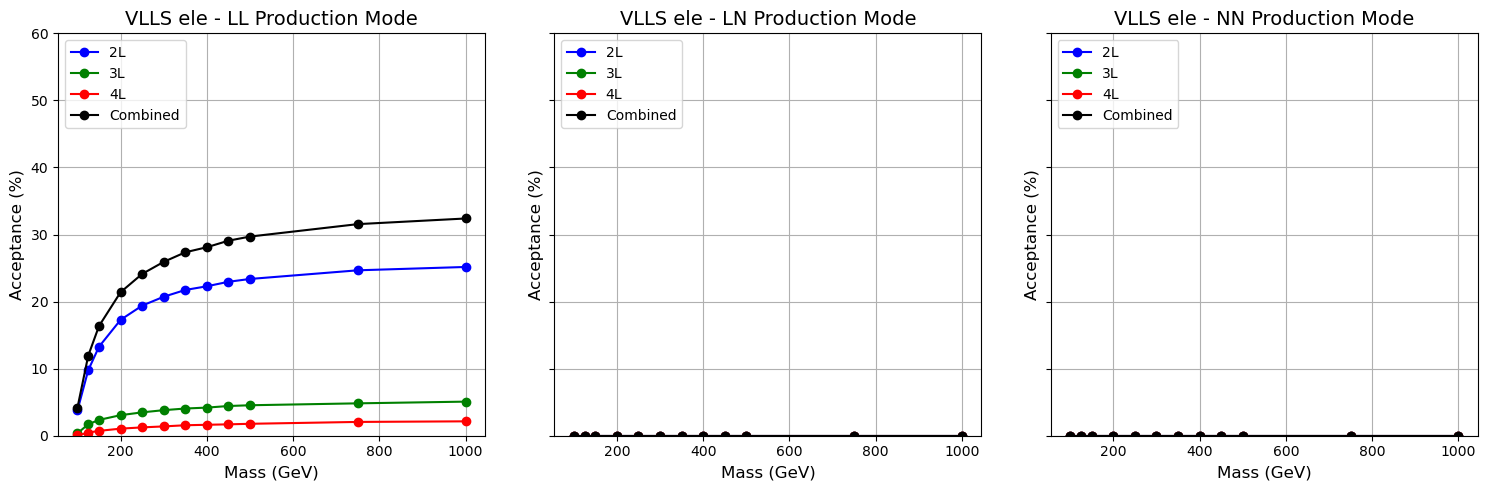

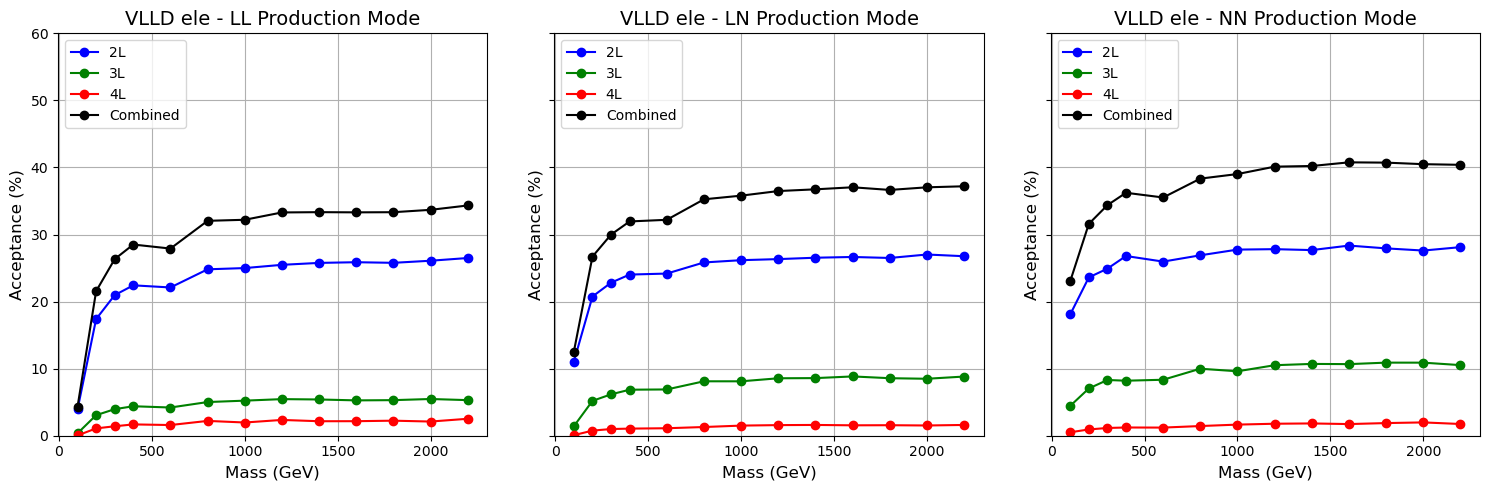

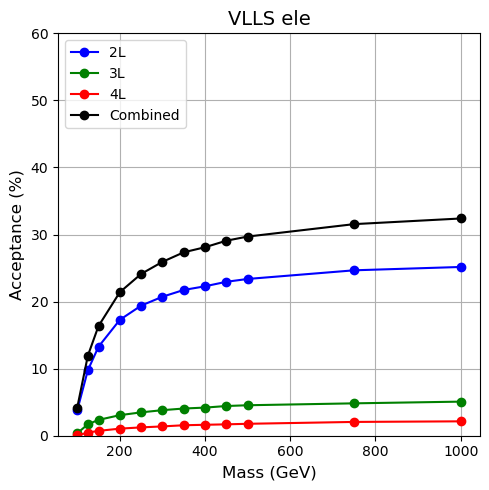

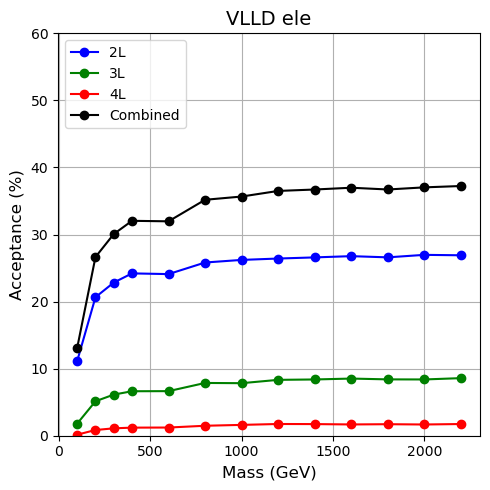

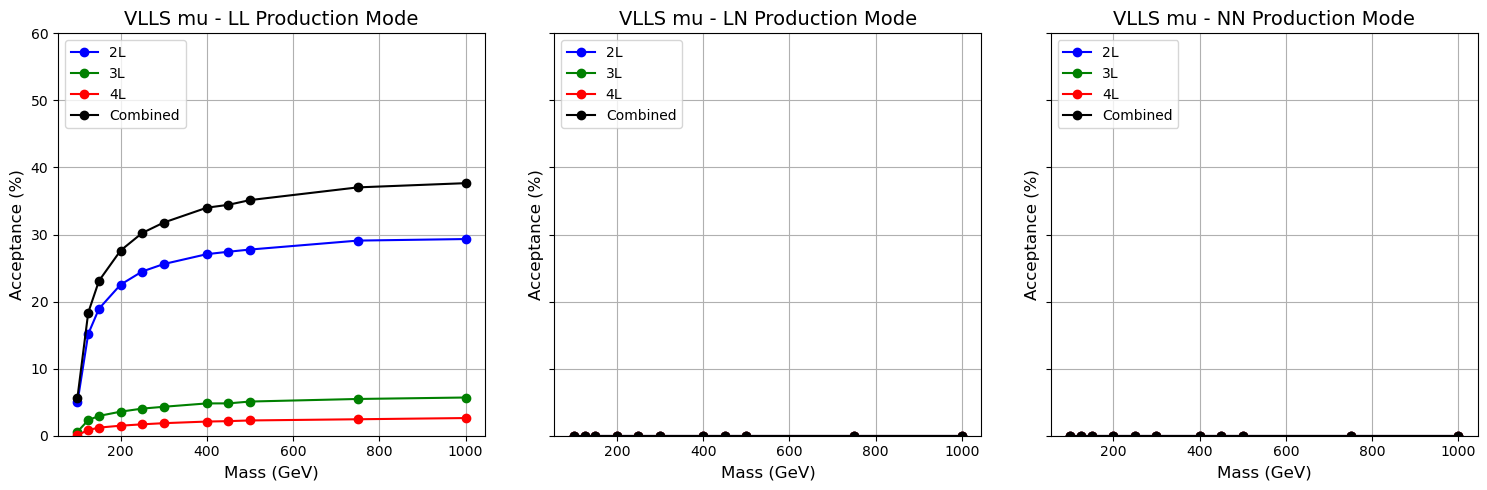

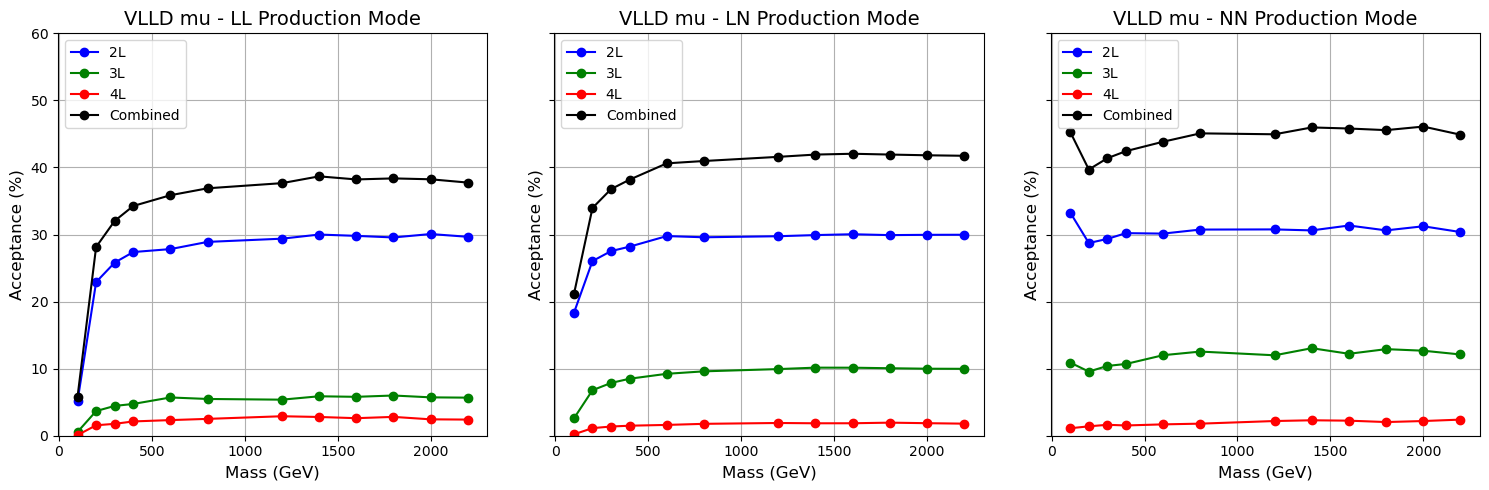

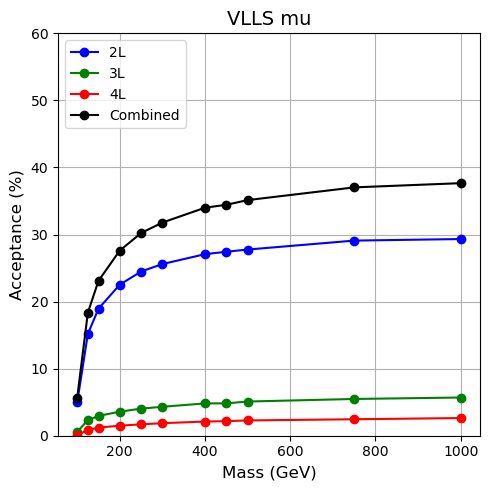

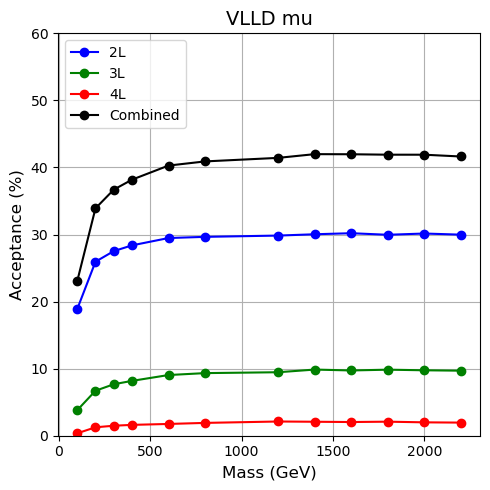

Done!


In [5]:
# Call the function
make_plot('VLLS', 'ele')
make_plot('VLLD', 'ele')
make_combined_plot('VLLS', 'ele')
make_combined_plot('VLLD', 'ele')
make_plot('VLLS', 'mu')
make_plot('VLLD', 'mu')
make_combined_plot('VLLS', 'mu')
make_combined_plot('VLLD', 'mu')

print('Done!')